In [7]:
import numpy as np
import sys
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mapper import expand, parse_mapping_table, apply_mappers

# Section 1  (Refenece data setup)
## Load Onco Gene Data (Reference Information)
### The data below is a curated set of genes known to transform a cell into a tumor cell, or a gene known to suppress

#### OncoKB (Very popular source for cancer gene annotation)

In [3]:

# from http://oncokb.org/#/cancerGenes
OncoKB_mut = pd.read_csv("../data/allAnnotatedVariants.txt",sep ="\t", encoding='latin-1')
OncoKB_gtype = pd.read_csv("../data/allCuratedGenes.txt",sep ="\t")

OncoKB_gtype.head()

,Isoform,RefSeq,Entrez Gene ID,Hugo Symbol,Is Oncogene,Is Tumor Suppressor Gene,Highest Level of Evidence(sensitivity),Highest Level of Evidence(resistance),Summary
0,ENST00000318560,NM_005157.4,25,ABL1,Yes,No,1,R1,NaN
1,ENST00000502732,NM_007314.3,27,ABL2,Yes,No,NaN,NaN,NaN
2,ENST00000331925,NM_001199954.1,71,ACTG1,No,Yes,NaN,NaN,NaN
3,ENST00000263640,NM_001111067.2,90,ACVR1,Yes,No,NaN,NaN,NaN
4,ENST00000220592,NM_012154.3,27161,AGO2,No,No,NaN,NaN,NaN


#### Split out genes into category buckets

In [4]:

og_genes = []
tsg_genes = []
og_tsg_genes = [] 

for index, row in OncoKB_gtype.iterrows():
    if row['Is Oncogene'] == 'Yes':
        og_genes.append(row['Hugo Symbol'])
    
    if row['Is Tumor Suppressor Gene'] == 'Yes':
        tsg_genes.append(row['Hugo Symbol'])
        
    if row['Is Oncogene'] =='Yes' and row['Is Tumor Suppressor Gene'] == 'Yes':
        og_tsg_genes.append(row['Hugo Symbol'])

OncoKB = {"OG":set(og_genes),"TSG": set(tsg_genes),"OG_TSG": set(og_tsg_genes)}


print("OncoKB OG:",len(OncoKB["OG"]),"TSG:",len(OncoKB["TSG"]),"OG_TSG:",len(OncoKB["OG_TSG"]))

OncoKB OG: 276 TSG: 285 OG_TSG: 33


### Bailye (Another source of cancer genes)

In [9]:
bailye = {"OG":[],"TSG":[],"OG_TSG":[]}
bailye_drivers = pd.read_excel("../data/mmc1.xlsx", sheet_name="Table S1", 
                               skiprows = 3)
bailye_drivers = bailye_drivers[["Gene","Tumor suppressor or oncogene prediction (by 20/20+)"]]
#print(bailye_drivers.shape[0])
bailye_drivers.drop_duplicates(inplace=True)
bailye_drivers.columns = ["gene", "role"]
#print(bailye_drivers.shape[0])
bailye_drivers.fillna("NA", inplace = True)
bailye_drivers["role"] = bailye_drivers["role"].apply(lambda x: x.replace("possible ",""))
bailye_drivers.drop_duplicates(inplace=True)
#print(bailye_drivers.shape[0])
bailye_drivers.loc[bailye_drivers.duplicated("gene", keep=False),:]
#print(len(set(bailye_drivers["gene"].values)))
bailye["OG"] = bailye_drivers.loc[bailye_drivers["role"] == "oncogene",:]
bailye["OG"] = set(bailye["OG"]["gene"].values)
bailye["TSG"] = bailye_drivers.loc[bailye_drivers["role"] == "tsg",:]
bailye["TSG"] = set(bailye["TSG"]["gene"].values)
bailye["OG_TSG"] = bailye["OG"].intersection(bailye["TSG"])
print("Bailey_2018 OG:",len(bailye["OG"]),"TSG:",len(bailye["TSG"]),"both:", len(bailye["OG_TSG"]))

Bailey_2018 OG: 115 TSG: 162 both: 18


## NCBI
Below loads another set of standard reference genes for the human genome. These are all the genes, independent on if they are releated to cancer

In [8]:
NCBI = pd.read_csv("../data/Homo_sapiens.gene_info",sep = "\t")
NCBI = NCBI[["#tax_id","GeneID","Symbol","Synonyms","type_of_gene"]]
NCBI = NCBI.loc[NCBI["#tax_id"] == 9606]
NCBI = NCBI.loc[NCBI["type_of_gene"] != "unknown"]
ncbi_symbols = parse_mapping_table(NCBI, "Symbol","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Symbol rows are not empty.
Ok: All Symbol are mapped to GeneID
13 Symbol mapped to multiple GeneID
Ok: All GeneID are unique
59665 Symbol can be mapped directly to GeneID


## Helper Methods

Methods below are used to score the impact that the mutations / variants from the WES file have on an individual gene. This allows us to represent all the mutations into a value that can be compared across cell lines

In [5]:
# gene_id - Entrez Gene ID 
# df - all mutations in sample
#    columns: "aa_pos","function", "Entrez_gene_ID"
# hotspots - table of known hotsport  "Entrez_gene_ID" and "aa_pos"

def distance_to_hotspot(gene_id,df_gene, hotspots):
    '''Returns minimal distance between point mutation in gene and known hotspot'''
    # consider only GoF because LoF affect the whole protein and not a certian point
    df_gene = df_gene.loc[df_gene["function"] == "point_mutation"]
    df_hotspots = hotspots.loc[hotspots["Entrez_gene_ID"] == gene_id, :]
    dist = 100000
    for s,e in set(df_gene["aa_pos"].values):
        for hs, he in set(df_hotspots["aa_pos"].values):
            dist = min(dist, abs(s-hs),abs(s-he), abs(e-hs), abs(e-he))
    return dist

def mutations2score(df,TSG,OG,hotspots, w=0.05,verbose = False):
    # define gene type
    gene_scores = {}
    for gene_id in list(set(df["Entrez_gene_ID"].values)):
        df_gene = df.loc[df["Entrez_gene_ID"] == gene_id, :]
        # functions of mutations
        mut_functions = set(df_gene["function"].values)
        if gene_id in TSG:
            # check for truncating mutations:
            # score is -1 if any
            if "truncating_mutation" in mut_functions:
                gene_scores[gene_id] =-1
            else:
                # in mutation is not truncating, 
                # get the distance to closets hotspot if any 
                dist = distance_to_hotspot(gene_id, df_gene, hotspots)
                # set abs. maximal of 1/(dist+1) and 2w which corresponds LoF in unannotatedd gene
                gene_scores[gene_id] = -max(1.0/(dist+1),2*w)
        elif gene_id in OG:
            if "point_mutation" in mut_functions:
                dist = distance_to_hotspot(gene_id, df_gene, hotspots)
                if "truncating_mutation" in mut_functions:
                    if verbose:
                        print("GoF at dist",dist,"from hotspot in Oncogene with GoF",file = sys.stderr)
                        print(df_gene,file = sys.stderr)
                    if 1.0/(dist+1) > 2*w:
                        # if there is a mutation close to hotspot
                        # despite LoF it is likely a driver and the second copy of this gene is broken
                        # this happens in sampl 905968  in PIK3CA gene (5290)
                        gene_scores[gene_id] = 1.0/(dist+1)
                    else:
                        # otherwise we set -1 to differentiate it from neutral mutations
                        # because oncogene might turn on after domain truncation
                        gene_scores[gene_id] = -1
                else:
                    # non-hotspot mutation in non-LoF oncogene - small positive value
                    gene_scores[gene_id] = max(1.0/(dist+1),w)
            else:
                # only LoF mutations, oncogene is likely not functional or
                # it is turned-on after truncting mutations
                # therefore we set -1 to differentiate it from neutral mutations
                gene_scores[gene_id] = -1
            
            
        else: # if unknown_significance
            if "truncating_mutation" in mut_functions:
                gene_scores[gene_id] = -2.0*w
            else:
                gene_scores[gene_id] = -w
    
    return pd.Series(gene_scores)

### Mutation / Hotspot Reference Sources

Here we are trying to understand the volatility of the gene by the mutations that are within them. These are outlined in the data files from other data sources similar to OncoKB 

In [11]:
hotspots2D_subst = pd.read_excel("../data/hotspots_v2.xls","SNV-hotspots")
hotspots2D_indels = pd.read_excel("../data/hotspots_v2.xls","INDEL-hotspots")
print("1D mutations",hotspots2D_subst.shape[0],hotspots2D_indels.shape[0] )
hotspots2D_subst = hotspots2D_subst.loc[~hotspots2D_subst["Amino_Acid_Position"].str.contains("splice")]
hotspots2D_subst = hotspots2D_subst[["Hugo_Symbol","Amino_Acid_Position"]]
hotspots2D_subst.drop_duplicates(inplace=True)
hotspots2D_indels = hotspots2D_indels[["Hugo_Symbol","Amino_Acid_Position"]]
hotspots2D_indels.drop_duplicates(inplace=True)
print("1D hotspots",hotspots2D_subst.shape[0],hotspots2D_indels.shape[0] )
cBioPortal_muts = pd.concat([hotspots2D_subst,hotspots2D_indels],axis =0)
cBioPortal_muts_ = cBioPortal_muts.loc[cBioPortal_muts["Amino_Acid_Position"].str.contains("-"),:]
cBioPortal_muts = cBioPortal_muts.loc[~cBioPortal_muts["Amino_Acid_Position"].str.contains("-"),:]
cBioPortal_muts["Amino_Acid_Position"] = cBioPortal_muts["Amino_Acid_Position"].apply(int)
#cBioPortal_muts["start"] = cBioPortal_muts["Amino_Acid_Position"]
#cBioPortal_muts["end"] = cBioPortal_muts["Amino_Acid_Position"]
cBioPortal_muts["aa_pos"] = cBioPortal_muts["Amino_Acid_Position"].apply(lambda x : (x,x))

#cBioPortal_muts_ ["start"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x: int(x.split("-")[0]))
#cBioPortal_muts_["end"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x: int(x.split("-")[1]))
cBioPortal_muts_["aa_pos"] = cBioPortal_muts_["Amino_Acid_Position"].apply(lambda x : tuple(map(int,x.split("-"))))

cBioPortal_muts = pd.concat([cBioPortal_muts_,cBioPortal_muts],axis = 0)
cBioPortal_muts["source"] = "1D"


### 3D

cBioPortal_3D = pd.read_excel("../data/3d_hotspots.xls","Table S5")
cBioPortal_3D = cBioPortal_3D[["Gene","Amino_Acid_Position"]]
print("3D mutations",cBioPortal_3D.shape[0])
cBioPortal_3D.drop_duplicates(inplace=True)
print("3D hotspots ",cBioPortal_3D.shape[0])
cBioPortal_3D["Amino_Acid_Position"] = cBioPortal_3D["Amino_Acid_Position"].apply(int)
#cBioPortal_3D["start"] = cBioPortal_3D["Amino_Acid_Position"]
#cBioPortal_3D["end"] = cBioPortal_3D["Amino_Acid_Position"]
cBioPortal_3D["aa_pos"] = cBioPortal_3D["Amino_Acid_Position"].apply(lambda x : (x,x))
cBioPortal_3D.rename({"Gene":'Hugo_Symbol'}, axis="columns",inplace=True)
cBioPortal_3D["source"] = "3D"
cBioPortal_muts = cBioPortal_muts[["Hugo_Symbol","aa_pos"]]
cBioPortal_3D = cBioPortal_3D[["Hugo_Symbol","aa_pos"]]
cBioPortal_muts = pd.concat([cBioPortal_3D, cBioPortal_muts],axis=0)
cBioPortal_muts.sort_values(["Hugo_Symbol"],ascending = True,inplace=True)

cBioPortal_genes = set(cBioPortal_muts["Hugo_Symbol"].values)
print("genes with hotspot",len(cBioPortal_genes))
cBioPortal_muts = cBioPortal_muts[["Hugo_Symbol","aa_pos"]]
cBioPortal_muts.drop_duplicates(inplace=True)
print("unique hotspots",cBioPortal_muts.shape[0])
#cBioPortal_muts

1D mutations 3004 495
1D hotspots 1024 55
3D mutations 9512
3D hotspots  3395
genes with hotspot 688
unique hotspots 4258


#### Compare mutaitons with onco genes

In [12]:
print("genes with and without mutations")
for kind in ["OG","TSG","OG_TSG"]:
    oncokb = OncoKB[kind].intersection(cBioPortal_genes) 
    b = bailye[kind].intersection(cBioPortal_genes)
    print(kind,"oncokb", len(oncokb),"/",len(OncoKB[kind]),
         "Bailye_2018", len(b),"/",len(bailye[kind]))

genes with and without mutations
OG oncokb 117 / 276 Bailye_2018 81 / 115
TSG oncokb 130 / 285 Bailye_2018 81 / 162
OG_TSG oncokb 16 / 33 Bailye_2018 14 / 18


In [13]:
for kind in ["OG","TSG","OG_TSG"]:
    oncokb = OncoKB[kind]#.intersection(cBioPortal_genes) 
    b = bailye[kind]#.intersection(cBioPortal_genes)
    print(kind,"oncokb", len(oncokb),
         "Bailye_2018", len(b),"union",len(b.union(oncokb)),
         "mutated:",
         len(b.union(oncokb).intersection(cBioPortal_genes)))

OG oncokb 276 Bailye_2018 115 union 335 mutated: 148
TSG oncokb 285 Bailye_2018 162 union 351 mutated: 142
OG_TSG oncokb 33 Bailye_2018 18 union 49 mutated: 29


In [14]:
# TSG - not necessarity with a hotspot, take union of OncoKB and  Bailye_2018
TSG = OncoKB["TSG"].union(bailye["TSG"])
# OG - must have a hotspot 
OG = OncoKB["OG"].union(bailye["OG"]).intersection(cBioPortal_genes)
print("TSG:",len(TSG),"with hotspots:",len(TSG.intersection(cBioPortal_genes)),
      "\nOG with hotspots:",len(OG))
# list of hotspots: 
hotspots = cBioPortal_muts.loc[cBioPortal_muts["Hugo_Symbol"].isin(OG|TSG),:]
print("Hotspots (all from cBioPortal):", cBioPortal_muts.shape[0],
      "\n\ton OG:", hotspots.loc[hotspots["Hugo_Symbol"].isin(OG)].shape[0],
      "\n\ton TSG:", hotspots.loc[hotspots["Hugo_Symbol"].isin(TSG)].shape[0])
hotspots.head(5)

TSG: 351 with hotspots: 142 
OG with hotspots: 148
Hotspots (all from cBioPortal): 4258 
	on OG: 1128 
	on TSG: 1056


,Hugo_Symbol,aa_pos
1456,ACVR1,"(206, 206)"
1307,ACVR1,"(258, 258)"
1128,ACVR1,"(328, 328)"
2542,ACVR1B,"(398, 398)"
2056,ACVR1B,"(401, 401)"


### Often gene come with multiple names - This attempts to clean this up

At the end we will have all genes translated to have

Entrez Gene Id

```Entrez Gene maintains records from genomes which have been completely sequenced, which have an active research community to submit gene-specific information, or which are scheduled for intense sequence analysis```

Hugo Symbol

``` The HUGO Gene Nomenclature Committee is a committee of the Human Genome Organisation that sets the standards for human gene nomenclature. ```





In [15]:
ncbi_synonyms = expand(NCBI[["Synonyms","GeneID"]],column="Synonyms",sep="|") 
ncbi_synonyms = parse_mapping_table(ncbi_synonyms, "Synonyms","GeneID")

Ok: no empty rows detected
Ok: no duplicated pairs detected
Ok: All Synonyms rows are not empty.
Ok: All Synonyms are mapped to GeneID
3198 Synonyms mapped to multiple GeneID
50201 different Synonyms mapped to the same GeneID
10893 Synonyms can be mapped directly to GeneID


In [16]:
tsg_og_gene_names = pd.DataFrame.from_dict({"genes":dict(zip(list(OG | TSG),list(OG | TSG)))})
tsg_og_gene_names, query2target, not_mapped = apply_mappers(tsg_og_gene_names, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")
OG_entrez = set(map(lambda x : query2target[x],OG))
TSG_entrez = set(map(lambda x : query2target[x],TSG))
hotspots["Entrez_gene_ID"] = hotspots["Hugo_Symbol"].apply(lambda x : query2target[x])
hotspots.head()

Mapped: 458 
	directly via main_mapper 446 
	via alternative mapper 2 
	via one of multiple synonyms in alternative mapper 10 
	LOC 0 
Unmapped: 0 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 0 
	LOC not found in Entrez 0 
	Not found at all: 0


IDs mapped to multiple target IDs are kept:
 []
/Users/kbloom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Hugo_Symbol,aa_pos,Entrez_gene_ID
1456,ACVR1,"(206, 206)",90
1307,ACVR1,"(258, 258)",90
1128,ACVR1,"(328, 328)",90
2542,ACVR1B,"(398, 398)",91
2056,ACVR1B,"(401, 401)",91


# Section 2
## Feature Mapping

All the code above preps out look up tables and reference information. Now, we need to run all the variants from the WES variants from the MOLI (GDSC dataset)

We will need to run the parts below against each patient WES file


## Load entire WES feature set used by MOLI paper (GDSC dataset)

In [19]:
wes_df = pd.read_csv('../data/WES_variants.csv')
wes_df.head()

,SAMPLE,COSMIC_ID,Cancer Type,Gene,Transcript,cDNA,AA,Classification,Gene_list,Recurrence Filter,Subs,Truncating,inframe
0,KARPAS-45,907272,ALL,A1BG,ENST00000263100,c.842A>G,p.Y281C,missense,NaN,NaN,NaN,NaN,NaN
1,Jurkat,998184,ALL,A1BG,ENST00000263100,c.589G>A,p.A197T,missense,NaN,NaN,NaN,NaN,NaN
2,KARPAS-45,907272,ALL,A1BG,ENST00000263100,c.571G>A,p.A191T,missense,NaN,NaN,2.0,NaN,NaN
3,HT-115,907289,COAD/READ,A1BG,ENST00000263100,c.1456G>A,p.D486N,missense,NaN,NaN,NaN,NaN,NaN
4,KM12,905989,COAD/READ,A1BG,ENST00000263100,c.770C>A,p.T257N,missense,NaN,NaN,NaN,NaN,NaN


In [20]:
mapped_wes_df  = wes_df[["COSMIC_ID","Gene","AA","Classification"]]
mapped_wes_df.head(3)

,COSMIC_ID,Gene,AA,Classification
0,907272,A1BG,p.Y281C,missense
1,998184,A1BG,p.A197T,missense
2,907272,A1BG,p.A191T,missense


/Users/kbloom/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kbloom/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


mean 485.7 median 288.0


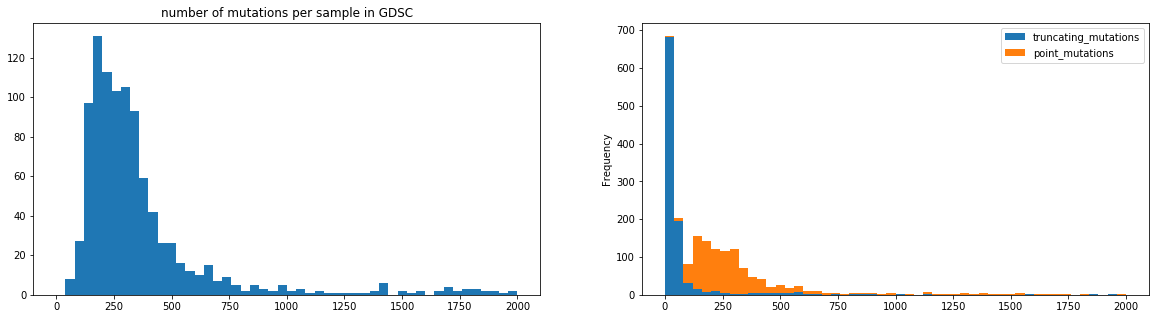

In [22]:
# define functional effect of a mutation 
gdsc_truncating = ['frameshift','nonsense','stop_lost','ess_splice']
gdsc_point = ['missense','Missense','inframe']
mapped_wes_df.loc[mapped_wes_df["Classification"].isin(gdsc_truncating),"function"] = "truncating_mutation"
mapped_wes_df.loc[mapped_wes_df["Classification"].isin(gdsc_point),"function"] = "point_mutation"
mapped_wes_df = mapped_wes_df.loc[mapped_wes_df["Classification"].isin(gdsc_truncating+gdsc_point),:]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
n_mutations_gdsc = mapped_wes_df.groupby("COSMIC_ID").size().sort_values(ascending = False)
tmp = plt.hist(n_mutations_gdsc, bins=50,range = (0,2000))
tmp = plt.title("number of mutations per sample in GDSC")
ax = plt.subplot(1,2,2)
n_LoF = mapped_wes_df.loc[mapped_wes_df["Classification"].isin(gdsc_truncating ),:].groupby("COSMIC_ID").size().sort_values(ascending = False)
n_GoF = mapped_wes_df.loc[mapped_wes_df["Classification"].isin(gdsc_point),:].groupby("COSMIC_ID").size().sort_values(ascending = False)
df = pd.DataFrame.from_dict({"truncating_mutations":n_LoF,"point_mutations":n_GoF})
#tmp = plt.hist(n_LoF, bins=50)
#tmp = plt.title("LoF mutations per sample in GDSC")
df.plot.hist(stacked = True, bins = 50,ax =ax,range = (0,2000))
print("mean",round(np.mean(n_mutations_gdsc),1), "median",np.median(n_mutations_gdsc))

### Helper funcs

In [23]:
def binarize(x):
    if x==0:
        return x
    else:
        return 1

def get_aa_pos_GDSC(x):
    l = re.findall(r'\d+', x)
    if len(l) == 0:
        #print(x, "positions not found.",file = sys.stderr)
        return ("NA","NA")
    elif len(l) == 1:
        return (int(l[0]), int(l[0]))
    else:
        return (int(l[0]), int(l[1]))

### Get actual position of mutations

In [24]:
mapped_wes_df["aa_pos"] = mapped_wes_df["AA"].apply(lambda x : get_aa_pos_GDSC(x))
mapped_wes_df.head(5)

,COSMIC_ID,Gene,AA,Classification,function,aa_pos
0,907272,A1BG,p.Y281C,missense,point_mutation,"(281, 281)"
1,998184,A1BG,p.A197T,missense,point_mutation,"(197, 197)"
2,907272,A1BG,p.A191T,missense,point_mutation,"(191, 191)"
3,907289,A1BG,p.D486N,missense,point_mutation,"(486, 486)"
4,905989,A1BG,p.T257N,missense,point_mutation,"(257, 257)"


### Look to see if mutaitons are in onco genes

In [25]:
ensg_genes = []
symbols = []
for gene in set(mapped_wes_df["Gene"].values):
    if gene.startswith("ENSG"):
        ensg_genes.append(gene)
        
    else:
        symbols.append(gene)
print("ENSEMBL gene IDs found:",len(ensg_genes))
ensg_genes = mapped_wes_df.loc[mapped_wes_df["Gene"].isin(ensg_genes), :]
gdsc_hugo =  mapped_wes_df.loc[mapped_wes_df["Gene"].isin(symbols), :]
print("Gene symbols:",len(set(gdsc_hugo["Gene"].values)))

ENSEMBL gene IDs found: 101
Gene symbols: 18989


### Map to Entrez

In [26]:
# mapping to Entrez
df = gdsc_hugo[["Gene"]].copy()
df.set_index("Gene",drop= False ,inplace=True)
df.drop_duplicates(inplace = True)
df, query2target,not_mapped  = apply_mappers(df, ncbi_symbols, ncbi_synonyms, verbose = True,handle_duplicates = "keep")

Mapped: 18466 
	directly via main_mapper 16773 
	via alternative mapper 472 
	via one of multiple synonyms in alternative mapper 1221 
	LOC 0 
Unmapped: 523 
	recognized symbols without Entrez ID 0 
	multiple query_ids map to the same target_id 0 
	query_ids map to multiple target_ids in the main mapper 0 
	query_ids map to multiple target_ids in the alternative mapper 64 
	LOC not found in Entrez 36 
	Not found at all: 423


IDs mapped to multiple target IDs are kept:
 [143872, 341019, 27177, 387119, 84530, 26165, 11321, 122945, 150082, 728642, 2122, 79949, 157777, 6241, 100289124, 8805, 127602, 387707, 345222, 84108, 91283, 84631, 144535, 245913, 388761, 4253, 163486, 54438, 283310, 84148, 57018, 284352, 5315, 339669, 23254, 23272, 119016, 340204, 64753, 64760, 25849, 286464, 129285, 4360, 10507, 4883, 5414, 23334, 256815, 23345, 57662, 54617, 84316, 200030, 10592, 57705, 246126, 92017, 126321, 10613, 374, 445815, 79741, 51586, 647060, 284565, 63895, 201625, 29086, 1954, 9127, 55719, 29099, 941, 155066, 140733, 114112, 85452, 139728, 84458, 23028, 54777, 79868]


### Map out to get entrez_gene_id 

### This value, entrez_gene_id is important, it will become the name of all of our feature columns


In [27]:
gdsc_hugo = gdsc_hugo.loc[~gdsc_hugo["Gene"].isin(not_mapped),:].copy()
gdsc_hugo["Entrez_gene_ID"] = gdsc_hugo["Gene"].apply(lambda x : query2target[x])
gdsc_hugo.head(10)

,COSMIC_ID,Gene,AA,Classification,function,aa_pos,Entrez_gene_ID
0,907272,A1BG,p.Y281C,missense,point_mutation,"(281, 281)",1
1,998184,A1BG,p.A197T,missense,point_mutation,"(197, 197)",1
2,907272,A1BG,p.A191T,missense,point_mutation,"(191, 191)",1
3,907289,A1BG,p.D486N,missense,point_mutation,"(486, 486)",1
4,905989,A1BG,p.T257N,missense,point_mutation,"(257, 257)",1
5,909698,A1BG,p.R90H,missense,point_mutation,"(90, 90)",1
6,905971,A1BG,p.T46M,missense,point_mutation,"(46, 46)",1
7,909761,A1BG,p.P41fs*33,frameshift,truncating_mutation,"(41, 33)",1
8,1327769,A1BG,p.E249D,missense,point_mutation,"(249, 249)",1
9,1330931,A1BG,p.Y184*,nonsense,truncating_mutation,"(184, 184)",1


### Score each variant / mutation

In [28]:
w = 0.05



gdsc_scores = {}
for sample in list(set(gdsc_hugo["COSMIC_ID"].values)):
    df = gdsc_hugo.loc[gdsc_hugo["COSMIC_ID"] == sample,:]
    gdsc_scores[sample] = mutations2score(df, TSG_entrez,OG_entrez, hotspots, w=w)
gdsc_scores = pd.DataFrame.from_dict(gdsc_scores)
gdsc_scores.fillna(0,inplace=True)



### Save file with contious value scoring

In [29]:
gdsc_scores.to_csv("../data/GDSC.non_bin_mutations.tsv",sep = "\t")
gdsc_scores.loc[[7157,5290,3845,4893],:]

,907268,907269,907270,907271,907272,907273,907274,907275,907276,907277,...,753620,753621,688086,753623,753622,753624,688087,753618,917486,688121
7157,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,...,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0
5290,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Make decsion if we want to binarize the score

In [30]:
gdsc_scores = gdsc_scores.applymap(lambda x: binarize(x))
gdsc_scores.to_csv("../data/GDSC.binary_mutations.tsv",sep = "\t")
gdsc_scores.loc[[7157,5290,3845,2312,4893],:]

,907268,907269,907270,907271,907272,907273,907274,907275,907276,907277,...,753620,753621,688086,753623,753622,753624,688087,753618,917486,688121
7157,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5290,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2312,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Prep data for transpose

In [33]:
# load one back in 
cosmic_wes_binary = pd.read_csv("../data/GDSC.binary_mutations.tsv",sep = "\t")
cosmic_wes_binary.set_index("Unnamed: 0",drop= True ,inplace=True)
cosmic_wes_binary.index.names = ['Gene_ID']
cosmic_wes_binary.head()

,907268,907269,907270,907271,907272,907273,907274,907275,907276,907277,...,753620,753621,688086,753623,753622,753624,688087,753618,917486,688121
Gene_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
cosmic_wes_binary_transposed = cosmic_wes_binary.transpose()
cosmic_wes_binary_transposed.head()

Gene_ID,1,2,9,10,12,13,14,15,16,18,...,101060321,101927546,101927722,101928638,102724473,102724928,105375355,105378803,107403068,109731405
907268,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907272,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Save out file transposed with COSMIC ID as rows

In [37]:
cosmic_wes_binary_transposed.index.names = ['COSMIC_ID']
cosmic_wes_binary_transposed.to_csv("../data/wes_binary_scored_transposed.tsv",sep = "\t")


In [38]:
cosmic_wes_binary_transposed.head()

Gene_ID,1,2,9,10,12,13,14,15,16,18,...,101060321,101927546,101927722,101928638,102724473,102724928,105375355,105378803,107403068,109731405
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
907268,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907272,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
